In [10]:
using WAV
using GLMakie
using DSP

In [11]:
y, Fs, nbits, opts  = wavread("/Users/darwin/Downloads/Unknown-3.wav")

([0.00640888698995941; 0.0043641468550675985; … ; 0.0; 0.0;;], 44100.0f0, 0x0010, WAVChunk[WAVChunk(Symbol("fmt "), UInt8[0x10, 0x00, 0x00, 0x00, 0x01, 0x00, 0x01, 0x00, 0x44, 0xac, 0x00, 0x00, 0x88, 0x58, 0x01, 0x00, 0x02, 0x00, 0x10, 0x00])])

In [30]:
length(y)-4110

854211

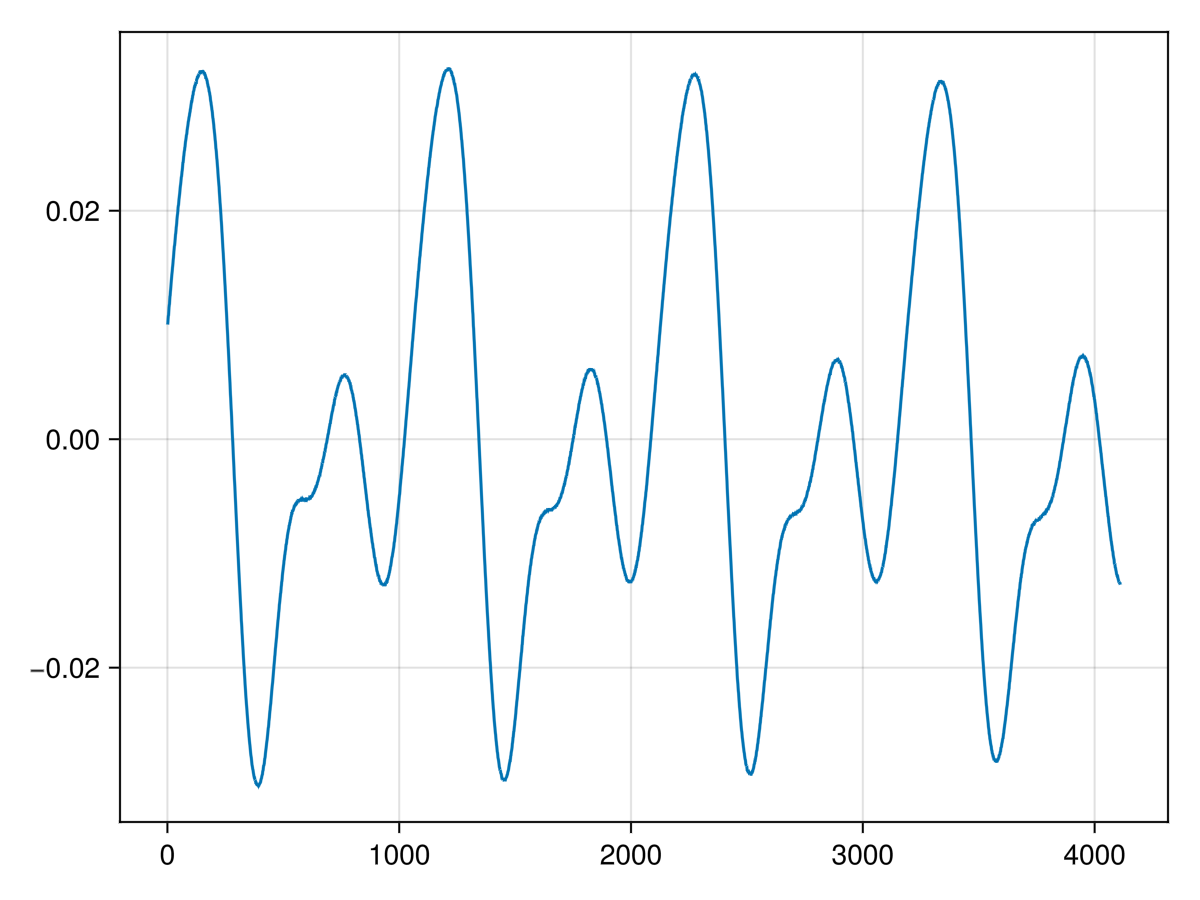

In [21]:
lines(y[end-2*4110:end-1*4110])

In [12]:
function difference(x::AbstractArray, τ)
    d = zero(eltype(x))
    N = length(x)
    for j in 1:N-τ
        d += (x[j] - x[j+τ])^2
    end
    return d
end

difference (generic function with 1 method)

In [13]:
function first_local_minimum(x, min_threshold = 1.0)
    for i in 2:length(x)-1
        
        if x[i-1] > x[i] && x[i] < x[i+1]
            if x[i] < min_threshold
                return (i, x[i])
            end
        end
    end
    return nothing
end

first_local_minimum (generic function with 2 methods)

In [43]:
length(y)

858321

In [42]:
60*4110

246600

In [52]:
floor(Int, Fs/90)

490

In [51]:
floor(Int, Fs/100)

441

In [66]:
using StatsBase

In [65]:
]add StatsBase

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `~/projects/daw/experiments/Project.toml`
  [2913bbd2] + StatsBase v0.34.4
  No Changes to `~/projects/daw/experiments/Manifest.toml`


In [57]:
using FFTW

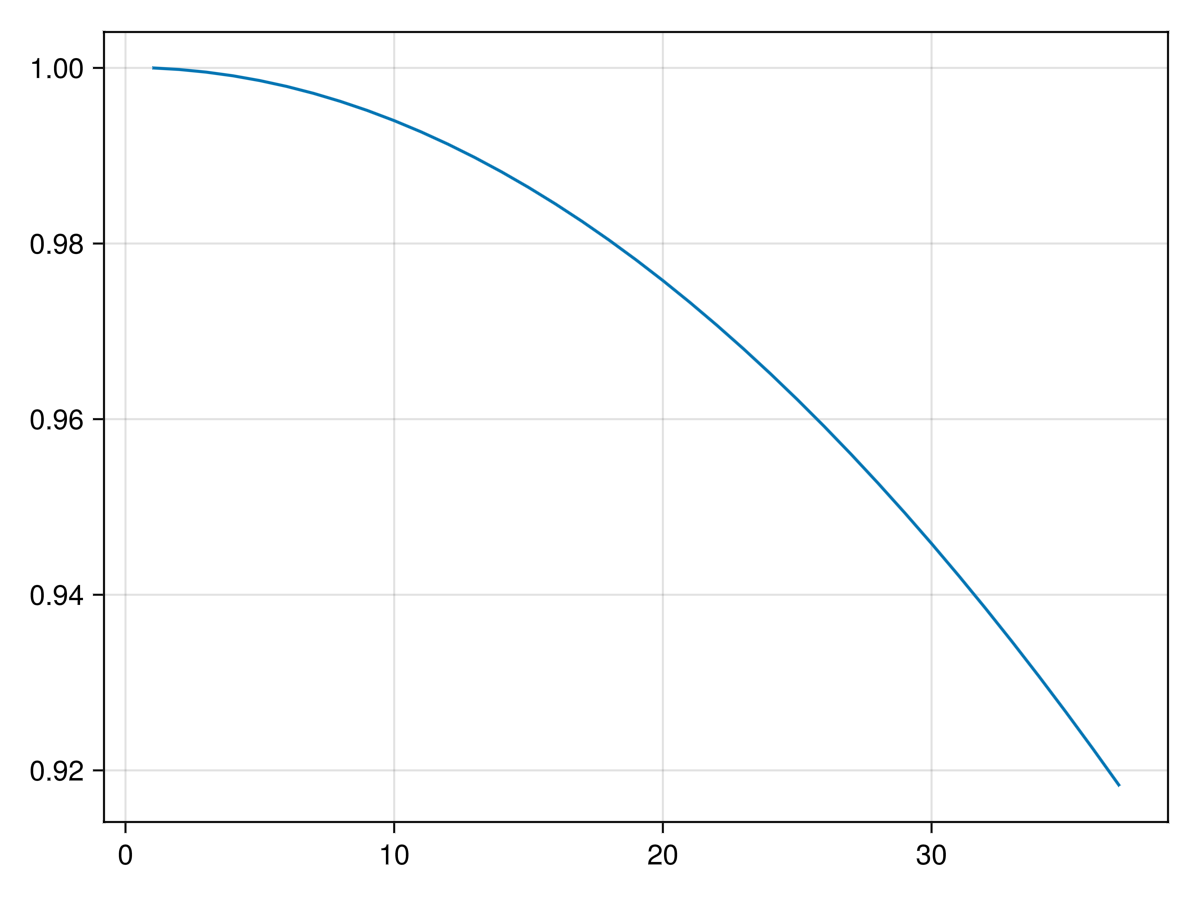

In [68]:
lines(autocor(y[end-2*4110:end-(1)*4110]))

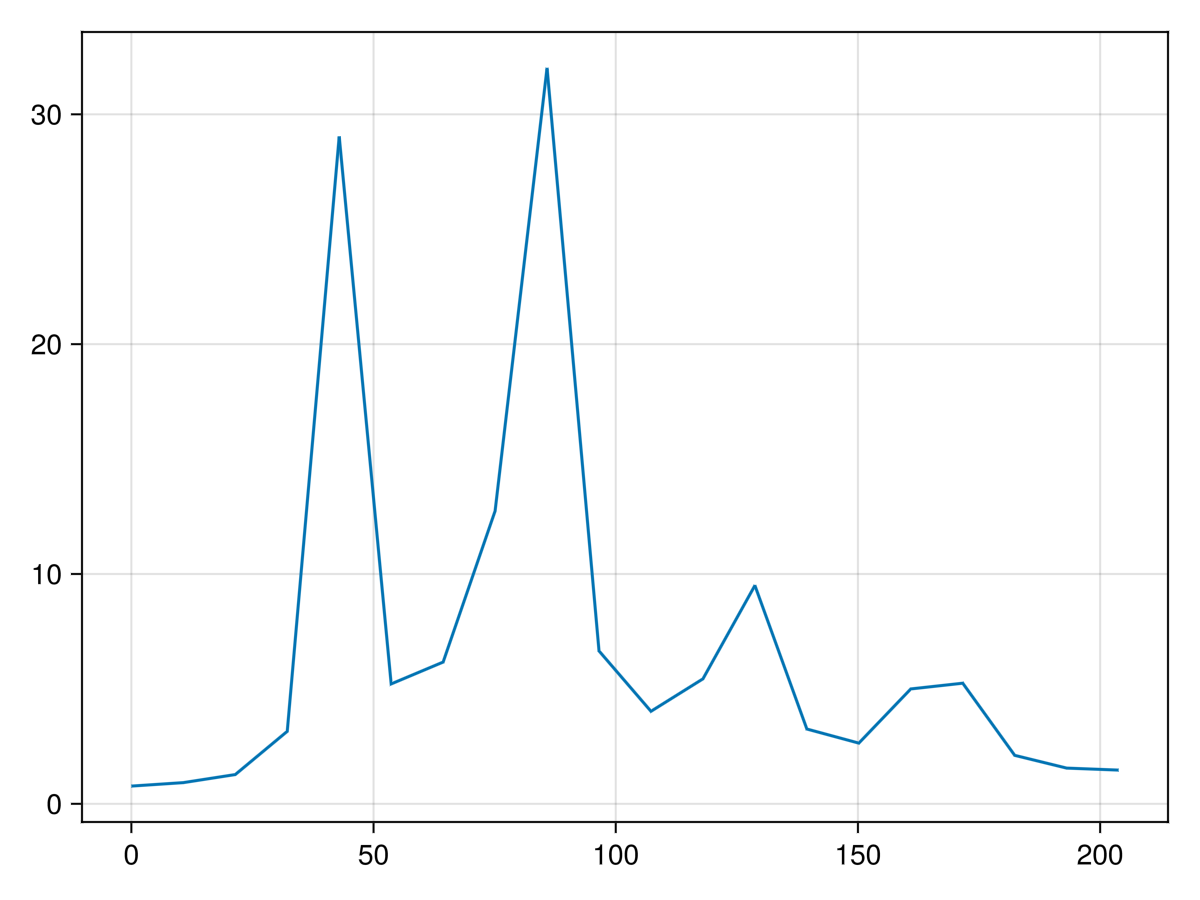

In [63]:
lines(rfftfreq(length(y[end-2*4110:end-(1)*4110]), Fs)[1:20], abs.(rfft(y[end-2*4110:end-(1)*4110]))[1:20])

In [54]:
d = [difference(y[end-2*4110:end-(1)*4110], j) for j in 441:490]
    d′ = [j*d[j]/sum(d[1:j]) for j in 1:length(d)]

50-element Vector{Float64}:
 1.0
 0.997618117867715
 0.9952387882191435
 0.9928646708937046
 0.9904947096074609
 0.9881288780210778
 0.9857707482271245
 0.9834203693467296
 0.9810779381864625
 0.9787446568423899
 0.9764198381662489
 0.9741038529077255
 0.9717965677167453
 ⋮
 0.9173888412406963
 0.9155925076883575
 0.9138203982306539
 0.9120777241022007
 0.9103677344939938
 0.9086852621788313
 0.9070331531570492
 0.9054119896430461
 0.9038215640651402
 0.9022646176737942
 0.9007367084462818
 0.8992434969874009

In [ ]:
    range = floor(Int, Fs/f_max):ceil(Int, Fs/f_min)
    d = [difference(y, j) for j ∈ range]
    d′ = [j*d[j]/sum(d[1:j]) for j in 1:length(range)]

In [50]:
length(y[end-2*4110:end-(1)*4110])

10.727317f0

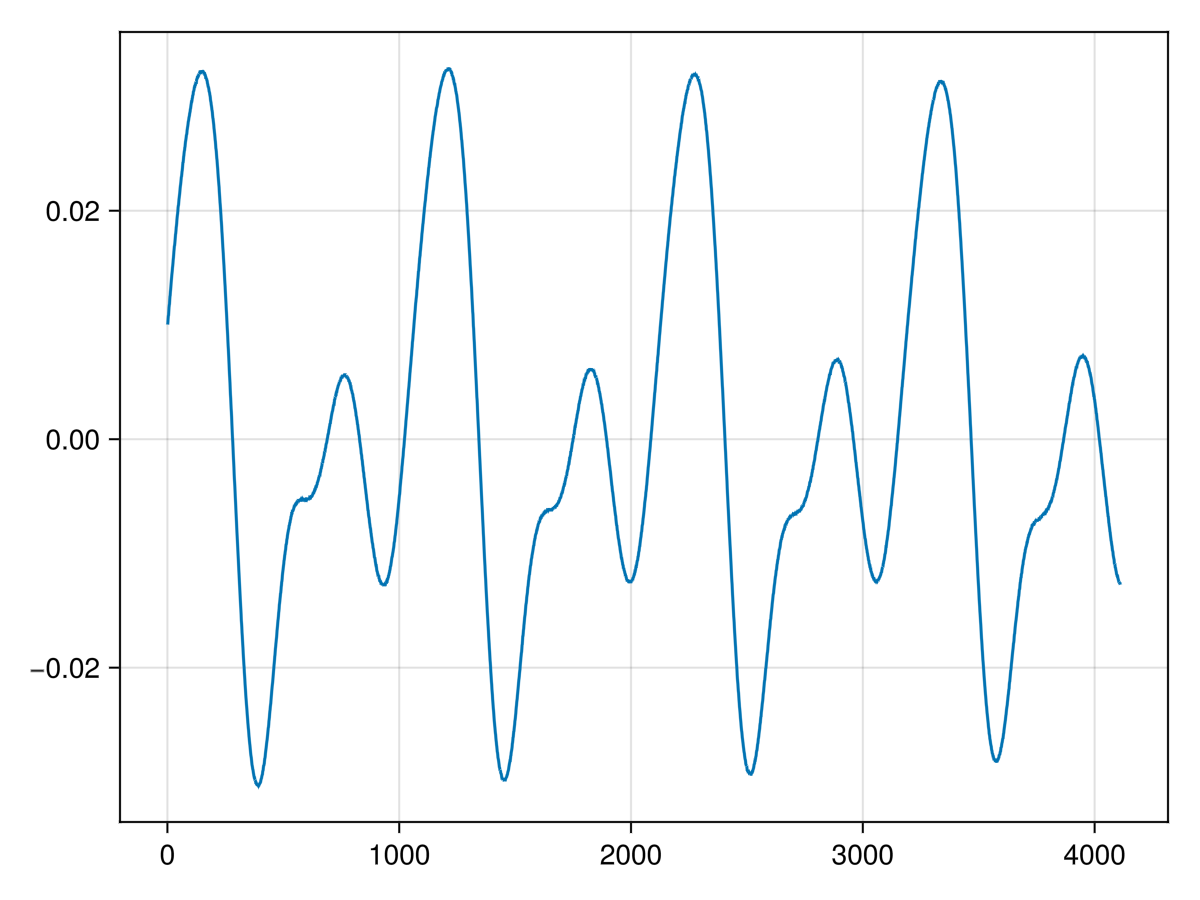

In [48]:
lines(y[end-2*4110:end-(1)*4110])

In [47]:
estimate_pitch(y[end-2*4110:end-(1)*4110], Fs, 90, 110)

LoadError: MethodError: no method matching getindex(::Nothing, ::Int64)

In [44]:
[estimate_pitch(y[end-i*4110:end-(i-1)*4110], Fs, 99, 100) for i in 2:60]

LoadError: MethodError: no method matching getindex(::Nothing, ::Int64)

In [41]:
[estimate_pitch(y[end-i*4110:end-(i-1)*4110], Fs, 99, 100) for i in 2:60]

LoadError: MethodError: no method matching getindex(::Nothing, ::Int64)

In [14]:
function estimate_pitch(y, Fs, f_min = 30, f_max = 150, interpolate = true)
    volume = sum(abs.(y))/length(y)
    if volume < 0.01
        return nothing
    end
    range = floor(Int, Fs/f_max):ceil(Int, Fs/f_min)
    d = [difference(y, j) for j ∈ range]
    d′ = [j*d[j]/sum(d[1:j]) for j in 1:length(range)]

#     ind = findfirst(x -> x < 0.1, d′)

    τ = first_local_minimum(d′, 0.25)[1] - 1
    interpolation = (d′[τ - 1] - d′[τ + 1])/(2*(2*d′[τ] - d′[τ - 1] - d′[τ + 1]))

    τ += range[1] - 1
    
    if interpolate
        τ += interpolation
    end


    return Fs/τ

end

estimate_pitch (generic function with 4 methods)

In [15]:
function make_resonator(f₀, fₛ, q)
    k = f₀/fₛ
    ω₀ = 2π*k
    α = sin(ω₀)/(2q)
    
    b₀ = α
    b₁ = 0.0
    b₂ = -α
    
    a₀ = 1 + α
    a₁ = -2cos(ω₀)
    a₂ = 1 - α
    
    return (b₀/a₀, b₁/a₀, b₂/a₀), (a₁/a₀, a₂/a₀)
end

make_resonator (generic function with 1 method)

In [16]:
function update_system(x, prev, feedforward_coeffs, feedback_coeffs)
    b₀, b₁, b₂ = feedforward_coeffs
    a₁, a₂ = feedback_coeffs # a₀ is assumed to be normalized to 1
    x₋, y₋ = prev

    # Apply the biquad filter equation
    y = b₀*x + b₁*x₋[2] + b₂*x₋[1] - a₁*y₋[2] - a₂*y₋[1]

    # Update state
    return y, ((x₋[2], x), (y₋[2], y))
end

update_system (generic function with 1 method)

In [5]:
candidates = 41.20344 .*[2^(i/12) for i in 1:3:12];

In [6]:
energies = []
fig = Figure()
ax = Axis(fig[1, 1], yautolimitmargin = (0.1, 0.1), xautolimitmargin = (0.1, 0.1))

n_sum = 2205
for (n, f) in enumerate(candidates)
    x₋ = (0.0, 0.0)
    y₋ = (0.0, 0.0)
    old_states = []
    sys = []
    e = zeros(n_sum)
    Σe = 0.0
    energy = zeros(length(y))
    feedforward_coeffs, feedback_coeffs = make_resonator(f, Fs, 10)
    for (i, sample) in enumerate(y)
        push!(old_states, x₋)
        output, new_state = update_system(sample, (x₋, y₋), feedforward_coeffs, feedback_coeffs)
        x₋ = new_state[1]
        y₋ = new_state[2]
        push!(sys, output)
        e[((i-1) % n_sum) + 1] = output*output
        Σe += output*output
        Σe -= e[(i % n_sum) + 1]
        energy[i] = Σe
    end
    lines!(ax, (1:length(y))./Fs, energy)
end

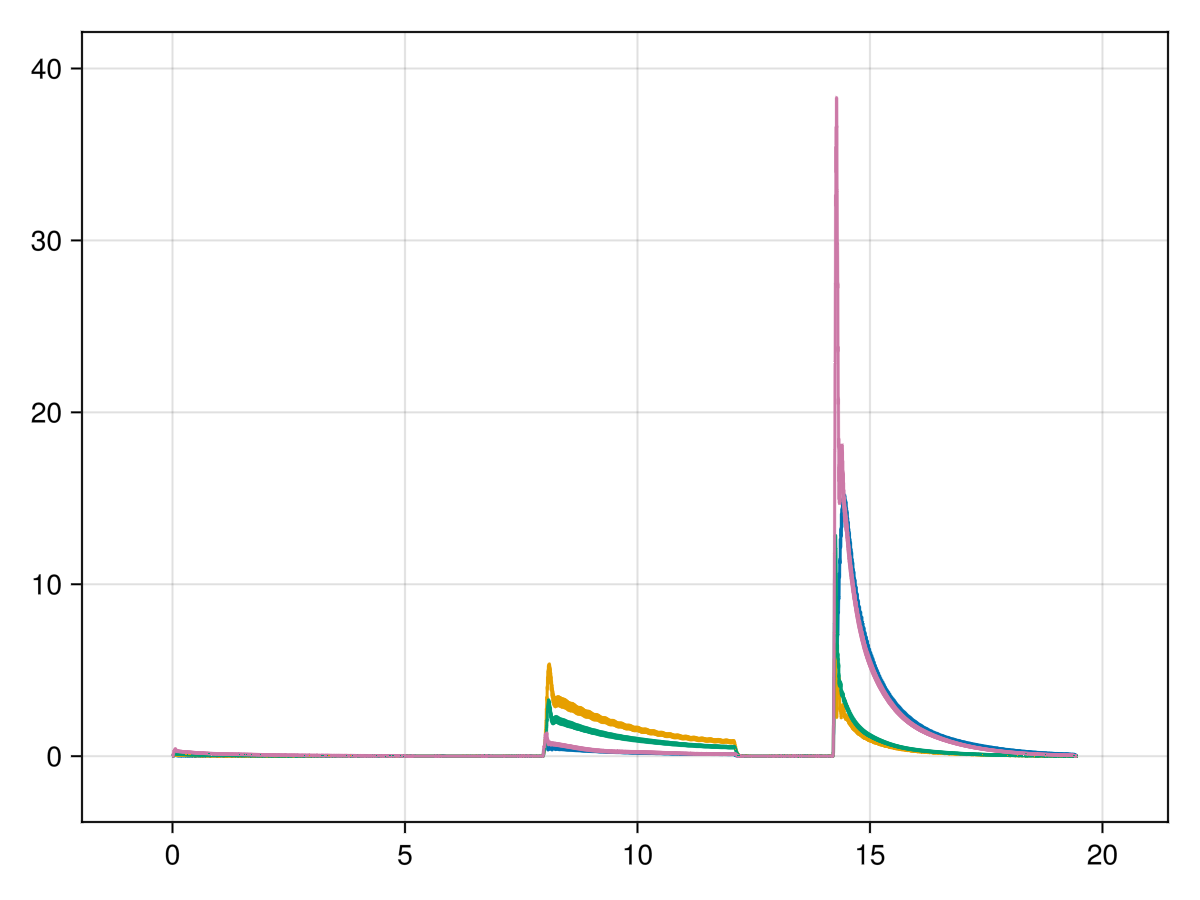

In [7]:
fig